# Tutorial de aplicación de la librería scikit-forecasts

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import skfore

import warnings
warnings.filterwarnings('ignore')

from skfore import datasets
import pandas

In [2]:
ts = datasets.load_champagne()
ts

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
              ... 
1972-05-01    4618
1972-06-01    5312
1972-07-01    4298
1972-08-01    1413
1972-09-01    5877
Name: Perrin, Length: 105, dtype: int64

<AxesSubplot:xlabel='Month'>

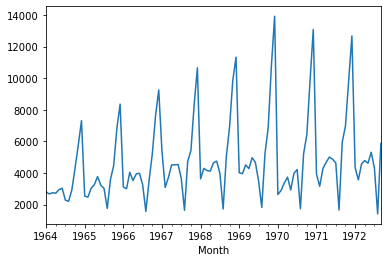

In [3]:
ts.plot()

## Análisis exploratorio de la serie

In [4]:
from skfore.skfore import series_viewer

viewer = series_viewer(ts)

viewer.describe()

count      105.000000
mean      4761.152381
std       2553.502601
min       1413.000000
25%       3113.000000
50%       4217.000000
75%       5221.000000
max      13916.000000
Name: Perrin, dtype: float64

<AxesSubplot:>

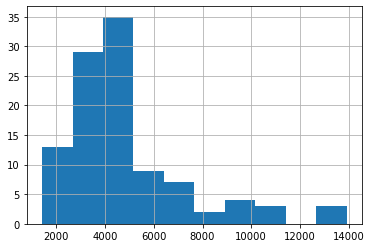

In [5]:
viewer.histogram()

<AxesSubplot:ylabel='Density'>

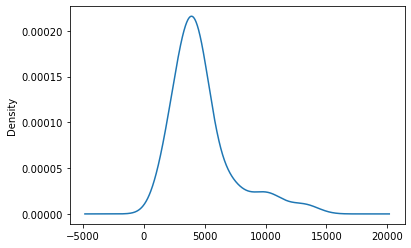

In [6]:
viewer.density_plot()

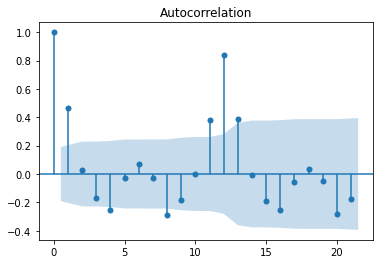

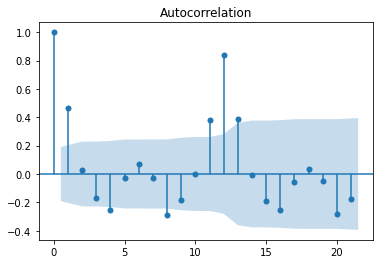

In [7]:
viewer.ACF_plot()

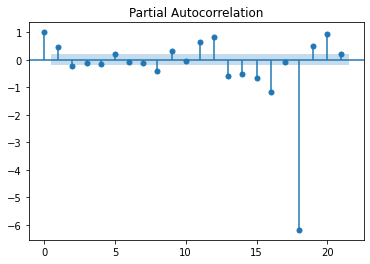

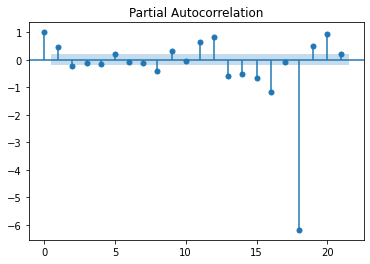

In [8]:
viewer.PACF_plot()

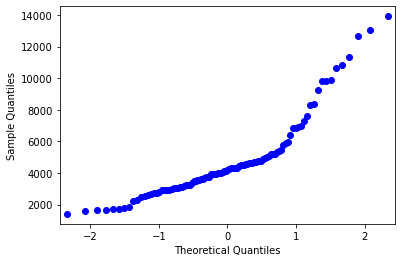

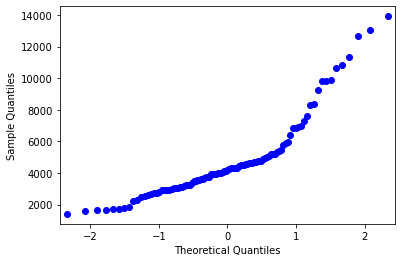

In [9]:
viewer.qq_plot()

In [10]:
viewer.normality()

,Jarque Bera normality test
Test statistics value,73.4391
p value,1.11022e-16


## Transformación de la serie de tiempo

<AxesSubplot:xlabel='Month'>

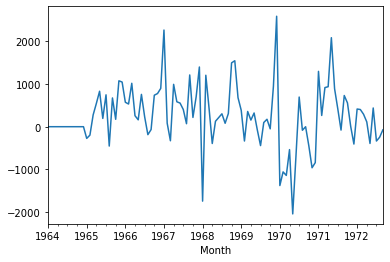

In [11]:
from skfore.preprocessing.transformer import transformer

my_transform = transformer(seasonal = 'diff')
t_ts = my_transform.fit_transform(ts = ts)

t_ts.plot()

<AxesSubplot:>

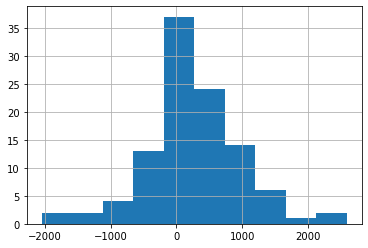

In [12]:
viewert = series_viewer(t_ts)
viewert.histogram()

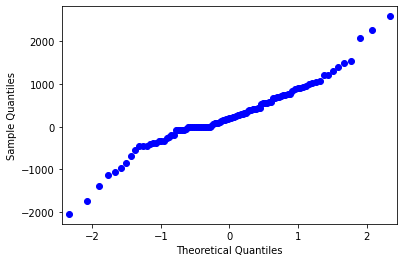

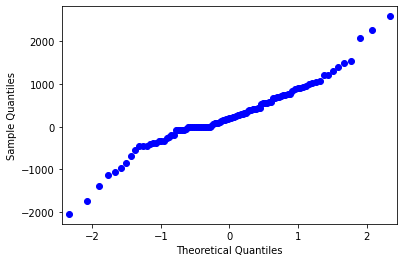

In [13]:
viewert.qq_plot()

## Pronóstico de la serie de tiempo

In [14]:
tse = ts[0:84]
tsp = ts[84:]

### Pronóstico no ciego

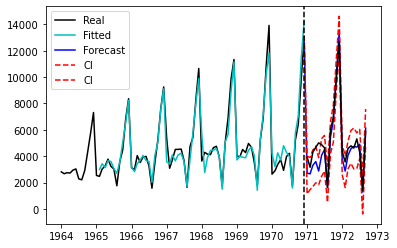

In [15]:
from skfore.models.AR import AR
import sklearn

model = AR(p = 13)
model.fit(tse)
forecast = model.predict(ts = tse, periods = 21, tsp = tsp, blind = False)

model.plot(tse, forecast)

In [16]:
MSE_E = model.calc_error(ts = tse)
MSE_P = model.calc_error(ts = tsp)

print('MSE Entrenamiento: ' + str(MSE_E))
print('MSE Prueba: ' + str(MSE_P))

MSE Entrenamiento: 512468.48211359634
MSE Prueba: 237782.1540769181


### Pronóstico ciego

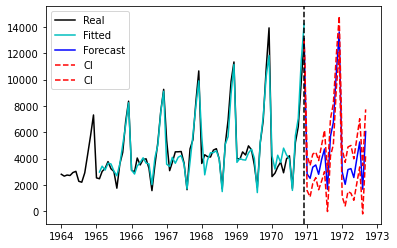

In [17]:
from skfore.models.AR import AR
import sklearn

model = AR(p = 13)
model.fit(tse)
forecast = model.predict(ts = tse, periods = 21)

model.plot(tse, forecast)

In [18]:
MSE_E = model.calc_error(ts = tse)
MSE_P = model.calc_error(ts = tsp)

print('MSE Entrenamiento: ' + str(MSE_E))
print('MSE Prueba: ' + str(MSE_P))

MSE Entrenamiento: 512468.48211272375
MSE Prueba: 237782.95958753082


## Transformación y pronóstico

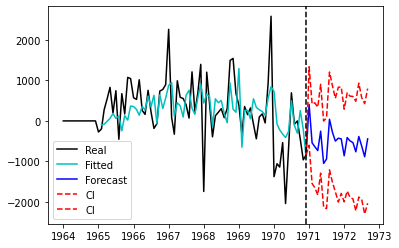

In [19]:
from skfore.preprocessing.transformer import transformer

my_transform = transformer(seasonal = 'diff')
t_ts = my_transform.fit_transform(ts = ts)

t_tse = t_ts[0:84]
t_tsp = t_ts[84:]

model = AR(p = 13)
model.fit(t_tse)
forecast = model.predict(ts = t_tse, periods = 21)

model.plot(t_tse, forecast)

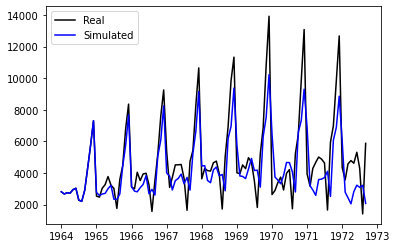

In [20]:
t_sim = model.simulate(ts = t_tse)
t_fore = forecast['forecast']
i_ts = pandas.concat([t_sim, t_fore])
ts_fore = my_transform.inverse_transform(ts = i_ts)

import matplotlib 

matplotlib.pyplot.plot(ts, 'k-')
matplotlib.pyplot.plot(ts_fore, 'b-')
matplotlib.pyplot.legend(['Real', 'Simulated'])

In [21]:
MSE_E = sklearn.metrics.mean_squared_error(tse, ts_fore[0:84])
MSE_P = sklearn.metrics.mean_squared_error(tsp, ts_fore[84:])

print('MSE Entrenamiento: ' + str(MSE_E))
print('MSE Prueba: ' + str(MSE_P))

MSE Entrenamiento: 1712474.9176202912
MSE Prueba: 4923398.605113503


## Pipeline

In [22]:
from skfore.models.AR import AR
from skfore.pipeline.Pipeline import Pipeline
import sklearn

my_model_12 = AR(p = 12)
my_model_13 = AR(p = 13)
my_transform = transformer(seasonal = 'diff')

my_pipeline = Pipeline(ts = ts, transformation = [my_transform], model = [my_model_12, my_model_13])
my_pipeline.fit()

transformer(trans = None, trend = None, seasonal = diff)
AR(p = 12, intercept = 237.51801337667752, phi = [-0.23646351  0.00027228  0.03748026 -0.03028631  0.09062316  0.04857521
 -0.035544   -0.07134899  0.01477273  0.09621678  0.05359052  0.19206935])
496403.11183967313
transformer(trans = None, trend = None, seasonal = diff)
AR(p = 13, intercept = 187.21187970693828, phi = [ 0.28428963 -0.29453714 -0.01918723  0.00604923 -0.03503542  0.1119803
  0.05441555 -0.05285136 -0.09858519  0.02353689  0.08296506  0.05095918
  0.25452534])
459631.45320513204


[496403.11183967313, 459631.45320513204]

## Búsqueda del mejor modelo

In [23]:
from skfore.pipeline._search import GridSearchCV
from skfore.models.AR import AR

model = AR()
parameters = {'p' : [11, 12, 13, 14, 15]}

my_gs = GridSearchCV(model, parameters)
result = my_gs.fit(ts)

print(result.best_score_)
print(result.best_model_)

489196.19240978354
AR(p = 13, intercept = 1363.1501615215136, phi = [-0.13447873  0.9056278   0.05443421 -0.07849291  0.06473044 -0.12623305
  0.05777576 -0.07094588  0.04009908 -0.1026351   0.04614774 -0.0973326
  0.21275117])


## Carga automática de múltiples series de tiempo

In [24]:
from skfore.file_reader import file_reader

times = file_reader.read_dir('/media/datos/D61EACF21EACCD35/Personal/Tesis/scikit-forecasts/skfore/datasets/', '*')
print(times)

[         Perrin
Month          
1964-01    2815
1964-02    2672
1964-03    2755
1964-04    2721
1964-05    2946
...         ...
1972-05    4618
1972-06    5312
1972-07    4298
1972-08    1413
1972-09    5877

[105 rows x 1 columns],          Perrin
Month          
1964-01    2815
1964-02    2672
1964-03    2755
1964-04    2721
1964-05    2946
1964-06    3036
1964-07    2282
1964-08    2212
1964-09    2922
1964-10    4301
1964-11    5764
1964-12    7312,             Valor
Fecha            
1996-04-30  32.23
1996-05-31  32.03
1996-06-30  31.92
1996-07-31  32.45
1996-08-31  31.86
...           ...
2008-01-31  88.12
2008-02-29  87.46
2008-03-31  87.82
2008-04-30  86.52
2008-05-31  87.27

[146 rows x 1 columns], Empty DataFrame
Columns: []
Index: [],               Valor
Fecha              
1995-07-31  3365.58
1995-08-31  3322.38
1995-09-30  3441.70
1995-10-31  3383.21
1995-11-30  3405.50
...             ...
2009-11-30  4764.01
2009-12-31  4617.73
2010-01-31  4411.70
2010-02-28  4888.72
201

In [25]:
module_path

'/media/datos/D61EACF21EACCD35/Personal/Tesis/scikit-forecasts'

In [32]:
from skfore.preprocessing.transformer import transformer
from skfore.datasets import load_passengers

ts=load_passengers()
ts

Month
1949-01    112
1949-02    118
1949-03    132
1949-04    129
1949-05    121
          ... 
1960-08    606
1960-09    508
1960-10    461
1960-11    390
1960-12    432
Name: passengers, Length: 144, dtype: int64

In [33]:
my_transform = transformer(trans='log', trend='diff1', seasonal='diff')
t_ts = my_transform.fit_transform(ts=ts)
t_ts

Month
1949-01    0.000000
1949-02    0.000000
1949-03    0.000000
1949-04    0.000000
1949-05    0.000000
             ...   
1960-08   -0.045934
1960-09    0.012024
1960-10    0.031830
1960-11   -0.050082
1960-12   -0.009964
Length: 144, dtype: float64

In [34]:
original_ts = my_transform.inverse_transform(ts = t_ts)
original_ts

Month
1949-01    1.000000
1949-02    1.053571
1949-03    1.178571
1949-04    1.151786
1949-05    1.080357
             ...   
1960-08    5.410714
1960-09    4.535714
1960-10    4.116071
1960-11    3.482143
1960-12    3.857143
Length: 144, dtype: float64

# Super AR

In [4]:
from skfore.models.super_model import superAR
from skfore.datasets import load_passengers
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot

ts = load_passengers()


model = superAR(p = 5, model = MLPRegressor, hidden_layer_sizes=(100, ))
model.fit(ts)



superAR(p = 5, model = MLPRegressor())

In [5]:
model.predict(ts, 2)

,ci_inf,ci_sup,bootstrap,series,forecast,real
1961-01-01 00:00:00,448.946972,628.710496,552.782359,575.495543,552.782359,None
1961-02-01 00:00:00,406.020138,588.461461,509.030465,534.830566,509.030465,None


In [8]:
from sklearn.ensemble import RandomForestRegressor


model2 = superAR(p = 5, model = RandomForestRegressor)
model2.fit(ts, max_depth=2, random_state=0)
forecast = model2.predict(ts, 2)
forecast

,ci_inf,ci_sup,bootstrap,series,forecast,real
1961-01-01 00:00:00,316.453350,423.838139,368.916043,368.762436,368.916043,None
1961-02-01 00:00:00,409.096126,519.778380,460.263725,457.548500,460.263725,None


In [6]:
from sklearn.ensemble import RandomForestRegressor


model3 = superAR(p = 5, model = RandomForestRegressor, max_depth=2, random_state=0)
model3.fit(ts)
forecast3 = model3.predict(ts, 2)
forecast3

,ci_inf,ci_sup,bootstrap,series,forecast,real
1961-01-01 00:00:00,318.131808,420.000000,370.088729,368.762436,370.088729,None
1961-02-01 00:00:00,409.096126,523.169631,461.448231,457.548500,461.448231,None
